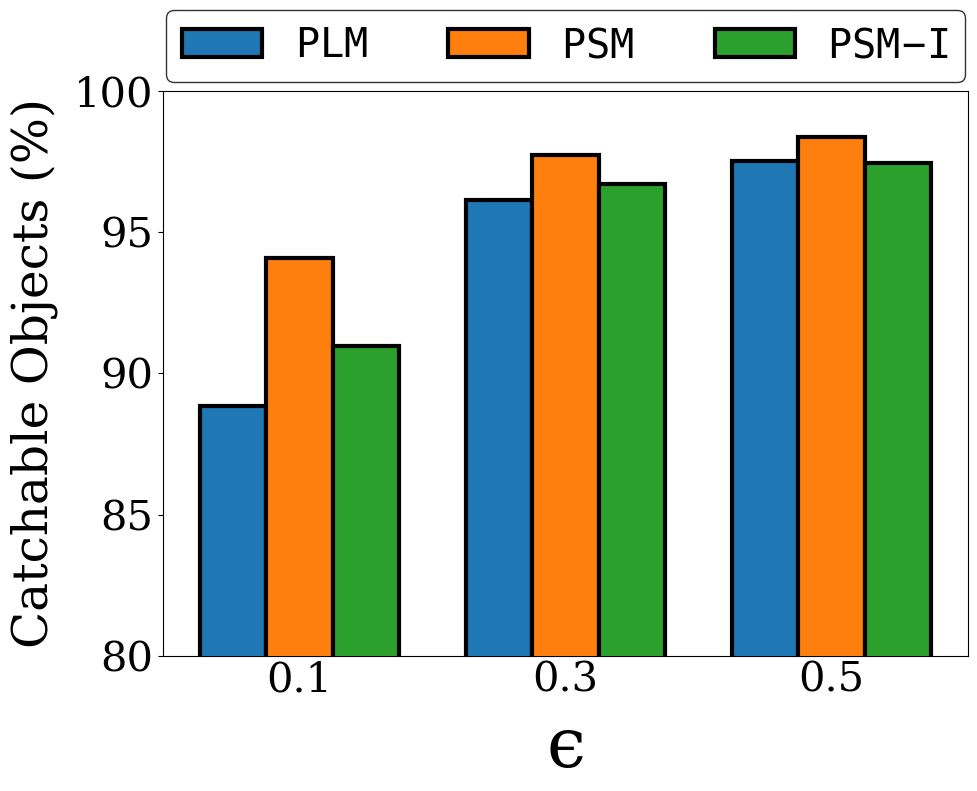

In [6]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from noise_distribution import (
    sample_laplace_radius,
    sample_psm_radius,
    sample_psm_radius_bounded
)
from util import haversine_distance, initial_bearing, destination_point



# --- set global font to Times New Roman ---
# ---- Camera-ready settings (avoid Type-3 fonts) ----
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'


# =============================================================================
# CONFIGURATION (MUST BE BEFORE FUNCTIONS THAT USE THESE)
# =============================================================================
EARTH_RADIUS        = 6_371_000

OVERLAY_RADIUS      = 100     # meters
POKEMON_MAX_RADIUS  = 1000    # meters
POKEMON_SPACING     = 25      # meters
DELTA_THRESHOLD     = 3.0     # meters (PSM-I refresh threshold baseline)
FIXED_CENTER        = (43.083789, -77.680391)


# =============================================================================
# MECHANISMS (NEW PLM / NEW PSM / BOUNDED PSM / PSM-I)
# =============================================================================
def planar_laplace_mechanism(lat: float, lon: float, epsilon: float, earth_radius: float = EARTH_RADIUS):
    r = sample_laplace_radius(epsilon)
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p


def planar_staircase_mechanism(lat: float, lon: float, epsilon: float, delta: float = 1.0, earth_radius: float = EARTH_RADIUS):
    r = sample_psm_radius(epsilon, delta=delta)
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p


def bounded_planar_staircase_mechanism(lat, lon, epsilon, r_b, earth_radius: float = EARTH_RADIUS, delta_step: float = 1.0):
    r = sample_psm_radius_bounded(epsilon, L=r_b, delta=delta_step)  # <= r_b
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p


def apply_psmi_to_dataframe(
    df,
    epsilon,
    delta,
    r_b=50.0,
    thr_L=2.0,                       # <-- NEW: threshold-noise bound (so no hardcoding)
    earth_radius: float = EARTH_RADIUS,
    use_noisy_threshold=True
):
    n = len(df)
    y_lat = np.zeros(n)
    y_lon = np.zeros(n)
    z_lat = np.zeros(n)
    z_lon = np.zeros(n)

    threshold = float(delta)
    if use_noisy_threshold:
        noise = sample_psm_radius_bounded(epsilon, L=thr_L, delta=delta)
        threshold = float(delta + noise)

    x1_lat, x1_lon = float(df.iloc[0]["latitude"]), float(df.iloc[0]["longitude"])
    y1_lat, y1_lon = bounded_planar_staircase_mechanism(
        x1_lat, x1_lon, epsilon, r_b, earth_radius=earth_radius, delta_step=delta
    )
    z1_lat, z1_lon = planar_staircase_mechanism(
        y1_lat, y1_lon, epsilon, delta=delta, earth_radius=earth_radius
    )

    y_lat[0], y_lon[0] = y1_lat, y1_lon
    z_lat[0], z_lon[0] = z1_lat, z1_lon

    y_ref_lat, y_ref_lon = y1_lat, y1_lon
    z_ref_lat, z_ref_lon = z1_lat, z1_lon

    for t in range(1, n):
        x_prev_lat, x_prev_lon = float(df.iloc[t-1]["latitude"]), float(df.iloc[t-1]["longitude"])
        x_cur_lat,  x_cur_lon  = float(df.iloc[t]["latitude"]),   float(df.iloc[t]["longitude"])

        d_h = float(haversine_distance(x_prev_lat, x_prev_lon, x_cur_lat, x_cur_lon, earth_radius))
        theta = float(initial_bearing(x_prev_lat, x_prev_lon, x_cur_lat, x_cur_lon))

        y_cur_lat, y_cur_lon = destination_point(y_lat[t-1], y_lon[t-1], d_h, theta, earth_radius)
        y_lat[t], y_lon[t] = y_cur_lat, y_cur_lon

        d_y = float(haversine_distance(y_ref_lat, y_ref_lon, y_cur_lat, y_cur_lon, earth_radius))
        if d_y < threshold:
            z_lat[t], z_lon[t] = z_ref_lat, z_ref_lon
        else:
            z_new_lat, z_new_lon = planar_staircase_mechanism(
                y_cur_lat, y_cur_lon, epsilon, delta=delta, earth_radius=earth_radius
            )
            z_lat[t], z_lon[t] = z_new_lat, z_new_lon
            y_ref_lat, y_ref_lon = y_cur_lat, y_cur_lon
            z_ref_lat, z_ref_lon = z_new_lat, z_new_lon

    return z_lat, z_lon


# =============================================================================
# POKEMON GENERATION (AFTER CONFIG AND HAVERSINE IMPORT IS READY)
# =============================================================================
def generate_uniform_pokemon_positions(center, max_radius, spacing):
    lat0, lon0 = center
    deg_lat = 1/111320.0
    deg_lon = 1/(111320.0 * math.cos(math.radians(lat0)))

    positions = []
    lat = lat0 - max_radius * deg_lat
    while lat <= lat0 + max_radius * deg_lat:
        lon = lon0 - max_radius * deg_lon
        while lon <= lon0 + max_radius * deg_lon:
            if haversine_distance(lat0, lon0, lat, lon, EARTH_RADIUS) <= max_radius:
                positions.append((lat, lon))
            lon += spacing * deg_lon
        lat += spacing * deg_lat
    return positions


POKEMONS = generate_uniform_pokemon_positions(FIXED_CENTER, POKEMON_MAX_RADIUS, POKEMON_SPACING)


# =============================================================================
# METRIC COMPUTATION
# =============================================================================
def compute_catch_and_loss(true_locs, pert_locs, overlay_radius=OVERLAY_RADIUS):
    total_true = total_intersect = acc_loss = 0
    for (lat_t, lon_t), (lat_p, lon_p) in zip(true_locs, pert_locs):
        V = [p for p in POKEMONS
             if haversine_distance(lat_t, lon_t, p[0], p[1], EARTH_RADIUS) <= overlay_radius]
        Vhat = [p for p in V
                if haversine_distance(lat_p, lon_p, p[0], p[1], EARTH_RADIUS) <= overlay_radius]

        total_true += len(V)
        total_intersect += len(Vhat)
        acc_loss += (len(V) - len(Vhat))

    catch_pct = (total_intersect / total_true) * 100 if total_true else 0
    return catch_pct, acc_loss


# =============================================================================
# SIMULATION PIPELINE (Monte Carlo)
# =============================================================================
def simulate_all_methods(
    users_trajs,
    epsilons,
    delta=DELTA_THRESHOLD,
    iterations=20,
    psm_delta=1.0,
    psmi_r_b=50.0,
    psmi_thr_L=2.0,                 # <-- NEW: pass threshold-noise bound
    use_noisy_threshold=True
):
    mechanisms = ['laplace', 'psm', 'psmi']
    results = {m: [] for m in mechanisms}

    for eps in epsilons:
        mech_user_cp = {m: [] for m in mechanisms}
        mech_user_loss = {m: [] for m in mechanisms}

        for traj in users_trajs:
            user_cp = {m: [] for m in mechanisms}
            user_loss = {m: [] for m in mechanisms}

            for _ in range(iterations):
                pert_l = [planar_laplace_mechanism(lat, lon, eps, EARTH_RADIUS) for lat, lon in traj]
                cp, loss = compute_catch_and_loss(traj, pert_l)
                user_cp['laplace'].append(cp)
                user_loss['laplace'].append(loss)

                pert_s = [planar_staircase_mechanism(lat, lon, eps, delta=psm_delta, earth_radius=EARTH_RADIUS) for lat, lon in traj]
                cp, loss = compute_catch_and_loss(traj, pert_s)
                user_cp['psm'].append(cp)
                user_loss['psm'].append(loss)

                df = pd.DataFrame(traj, columns=['latitude', 'longitude'])
                z_lat, z_lon = apply_psmi_to_dataframe(
                    df, eps, delta,
                    r_b=psmi_r_b,
                    thr_L=psmi_thr_L,            # <-- NEW
                    earth_radius=EARTH_RADIUS,
                    use_noisy_threshold=use_noisy_threshold
                )
                pert_i = list(zip(z_lat, z_lon))
                cp, loss = compute_catch_and_loss(traj, pert_i)
                user_cp['psmi'].append(cp)
                user_loss['psmi'].append(loss)

            for m in mechanisms:
                mech_user_cp[m].append(np.mean(user_cp[m]))
                mech_user_loss[m].append(np.mean(user_loss[m]))

        for m in mechanisms:
            avg_cp_all = float(np.mean(mech_user_cp[m]))
            total_loss_all = float(np.sum(mech_user_loss[m]))
            results[m].append((avg_cp_all, total_loss_all))

    return results


# =============================================================================
# PLOTTING
# =============================================================================
def plot_score_vs_epsilon(data_dir, dataset_name, scores_dict, epsilon_values):
    import os
    os.makedirs(data_dir, exist_ok=True)

    fig, ax = plt.subplots(figsize=(10, 8))

    attrs = {
        'laplace': {'label': r'$\mathtt{PLM}$'},
        'psm':     {'label': r'$\mathtt{PSM}$'},
        'psmi':    {'label': r'$\mathtt{PSM\!-\!I}$'},
    }

    x = np.arange(len(epsilon_values))  # group centers
    w = 0.25

    for i, key in enumerate(['laplace', 'psm', 'psmi']):
        vals = [scores_dict[key][j] for j in range(len(epsilon_values))]
        ax.bar(
            x + (i - 1) * w, vals, w,
            label=attrs[key]['label'],
            edgecolor='black', linewidth=3, zorder=3
        )

    # --- FIX: show epsilon tick labels + x-axis label ---
    
    # X-axis: epsilon symbol

# Y-axis: label

    ax.set_xticks(x)
    ax.set_xticklabels([str(eps) for eps in epsilon_values], fontsize=30)
    ax.set_xlabel('ϵ', fontsize=50, labelpad=10)
    ax.set_ylabel('Catchable Objects (%)', fontsize=35, labelpad=12)

    ax.tick_params(axis='x', length=0)  # optional: no tick marks

    ax.set_ylim(80, 100)
    ax.tick_params(axis='y', labelsize=30)
    #ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=1)

    leg = ax.legend(
        fontsize=29, frameon=True,
        loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=3
    )
    leg.get_frame().set_edgecolor('black')

    plt.tight_layout()
    fn = f"{dataset_name}_score_vs_epsilon_bar.pdf"
    path = os.path.join(data_dir, fn)
    fig.savefig(path, format='pdf', bbox_inches='tight', pad_inches=0)
    plt.show()


# =============================================================================
# USAGE EXAMPLE
# =============================================================================
if __name__ == "__main__":
    user_A = [
        (43.083789, -77.680391),
        (43.083821, -77.680348),
        (43.083866, -77.680350),
        (43.083868, -77.680411),
        (43.083835, -77.680452),
        (43.083830, -77.680513),
        (43.083785, -77.680513),
        (43.083828, -77.680532),
        (43.083785, -77.680515),
        (43.083828, -77.680532)
    ]

    user_B = [
        (43.083789, -77.680391),
        (43.083825, -77.680336),
        (43.083773, -77.680315),
        (43.083827, -77.680314),
        (43.083823, -77.680241),
        (43.083870, -77.680278),
        (43.083818, -77.680299),
        (43.083814, -77.680373),
        (43.083858, -77.680330),
        (43.083908, -77.680301)
    ]

    user_C = [
        (43.083789, -77.680391),
        (43.083797, -77.680476),
        (43.083734, -77.680464),
        (43.083796, -77.680448),
        (43.083738, -77.680415),
        (43.083687, -77.680465),
        (43.083645, -77.680401),
        (43.083590, -77.680358),
        (43.083591, -77.680273),
        (43.083535, -77.680310)
    ]

    user_D = [
        (43.083789, -77.680391),
        (43.083862, -77.680342),
        (43.083831, -77.680444),
        (43.083863, -77.680546),
        (43.083819, -77.680453),
        (43.083793, -77.680557),
        (43.083718, -77.680598),
        (43.083781, -77.680529),
        (43.083730, -77.680443),
        (43.083776, -77.680351)
    ]

    user_E = [
        (43.083789, -77.680391),
        (43.083813, -77.680273),
        (43.083724, -77.680289),
        (43.083735, -77.680167),
        (43.083719, -77.680288),
        (43.083801, -77.680238),
        (43.083817, -77.680359),
        (43.083748, -77.680280),
        (43.083659, -77.680300),
        (43.083572, -77.680331)
    ]

    users_trajectories = [user_A, user_B, user_C, user_D, user_E]

    epsilons = [0.1, 0.3, 0.5]
    data_dir =r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\figures"
    dataset_name = "pokemon_dense"

    metrics = simulate_all_methods(
        users_trajectories,
        epsilons,
        delta=DELTA_THRESHOLD,
        iterations=20,
        psm_delta=1.0,
        psmi_r_b=50.0,
        psmi_thr_L=2.0,   # <-- controls your “L=2 gives better results”
        use_noisy_threshold=True
    )

    scores = {k: [metrics[k][i][0] for i in range(len(epsilons))] for k in metrics}
    plot_score_vs_epsilon(data_dir, dataset_name, scores, epsilons)


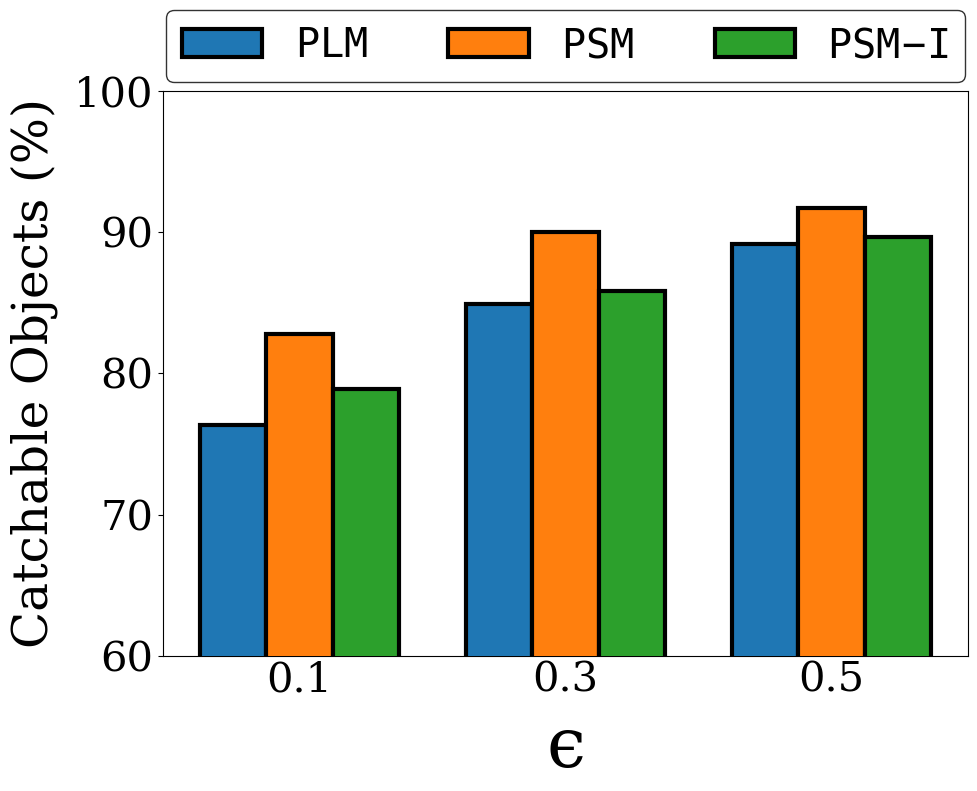

In [7]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from noise_distribution import (
    sample_laplace_radius,
    sample_psm_radius,
    sample_psm_radius_bounded
)
from util import haversine_distance, initial_bearing, destination_point



# --- set global font to Times New Roman ---
# ---- Camera-ready settings (avoid Type-3 fonts) ----
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'


# =============================================================================
# CONFIGURATION (MUST BE BEFORE FUNCTIONS THAT USE THESE)
# =============================================================================
EARTH_RADIUS        = 6_371_000

OVERLAY_RADIUS      = 100     # meters
POKEMON_MAX_RADIUS  = 1000    # meters
POKEMON_SPACING     = 100      # meters
DELTA_THRESHOLD     = 3.0     # meters (PSM-I refresh threshold baseline)
FIXED_CENTER        = (43.083789, -77.680391)


# =============================================================================
# MECHANISMS (NEW PLM / NEW PSM / BOUNDED PSM / PSM-I)
# =============================================================================
def planar_laplace_mechanism(lat: float, lon: float, epsilon: float, earth_radius: float = EARTH_RADIUS):
    r = sample_laplace_radius(epsilon)
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p


def planar_staircase_mechanism(lat: float, lon: float, epsilon: float, delta: float = 1.0, earth_radius: float = EARTH_RADIUS):
    r = sample_psm_radius(epsilon, delta=delta)
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p


def bounded_planar_staircase_mechanism(lat, lon, epsilon, r_b, earth_radius: float = EARTH_RADIUS, delta_step: float = 1.0):
    r = sample_psm_radius_bounded(epsilon, L=r_b, delta=delta_step)  # <= r_b
    theta = np.random.uniform(0, 2*np.pi)

    x = earth_radius * np.radians(lon)
    y = earth_radius * np.radians(lat)

    x_p = x + r * np.cos(theta)
    y_p = y + r * np.sin(theta)

    lon_p = np.degrees(x_p / earth_radius)
    lat_p = np.degrees(y_p / earth_radius)
    return lat_p, lon_p


def apply_psmi_to_dataframe(
    df,
    epsilon,
    delta,
    r_b=50.0,
    thr_L=2.0,                       # <-- NEW: threshold-noise bound (so no hardcoding)
    earth_radius: float = EARTH_RADIUS,
    use_noisy_threshold=True
):
    n = len(df)
    y_lat = np.zeros(n)
    y_lon = np.zeros(n)
    z_lat = np.zeros(n)
    z_lon = np.zeros(n)

    threshold = float(delta)
    if use_noisy_threshold:
        noise = sample_psm_radius_bounded(epsilon, L=thr_L, delta=delta)
        threshold = float(delta + noise)

    x1_lat, x1_lon = float(df.iloc[0]["latitude"]), float(df.iloc[0]["longitude"])
    y1_lat, y1_lon = bounded_planar_staircase_mechanism(
        x1_lat, x1_lon, epsilon, r_b, earth_radius=earth_radius, delta_step=delta
    )
    z1_lat, z1_lon = planar_staircase_mechanism(
        y1_lat, y1_lon, epsilon, delta=delta, earth_radius=earth_radius
    )

    y_lat[0], y_lon[0] = y1_lat, y1_lon
    z_lat[0], z_lon[0] = z1_lat, z1_lon

    y_ref_lat, y_ref_lon = y1_lat, y1_lon
    z_ref_lat, z_ref_lon = z1_lat, z1_lon

    for t in range(1, n):
        x_prev_lat, x_prev_lon = float(df.iloc[t-1]["latitude"]), float(df.iloc[t-1]["longitude"])
        x_cur_lat,  x_cur_lon  = float(df.iloc[t]["latitude"]),   float(df.iloc[t]["longitude"])

        d_h = float(haversine_distance(x_prev_lat, x_prev_lon, x_cur_lat, x_cur_lon, earth_radius))
        theta = float(initial_bearing(x_prev_lat, x_prev_lon, x_cur_lat, x_cur_lon))

        y_cur_lat, y_cur_lon = destination_point(y_lat[t-1], y_lon[t-1], d_h, theta, earth_radius)
        y_lat[t], y_lon[t] = y_cur_lat, y_cur_lon

        d_y = float(haversine_distance(y_ref_lat, y_ref_lon, y_cur_lat, y_cur_lon, earth_radius))
        if d_y < threshold:
            z_lat[t], z_lon[t] = z_ref_lat, z_ref_lon
        else:
            z_new_lat, z_new_lon = planar_staircase_mechanism(
                y_cur_lat, y_cur_lon, epsilon, delta=delta, earth_radius=earth_radius
            )
            z_lat[t], z_lon[t] = z_new_lat, z_new_lon
            y_ref_lat, y_ref_lon = y_cur_lat, y_cur_lon
            z_ref_lat, z_ref_lon = z_new_lat, z_new_lon

    return z_lat, z_lon


# =============================================================================
# POKEMON GENERATION (AFTER CONFIG AND HAVERSINE IMPORT IS READY)
# =============================================================================
def generate_uniform_pokemon_positions(center, max_radius, spacing):
    lat0, lon0 = center
    deg_lat = 1/111320.0
    deg_lon = 1/(111320.0 * math.cos(math.radians(lat0)))

    positions = []
    lat = lat0 - max_radius * deg_lat
    while lat <= lat0 + max_radius * deg_lat:
        lon = lon0 - max_radius * deg_lon
        while lon <= lon0 + max_radius * deg_lon:
            if haversine_distance(lat0, lon0, lat, lon, EARTH_RADIUS) <= max_radius:
                positions.append((lat, lon))
            lon += spacing * deg_lon
        lat += spacing * deg_lat
    return positions


POKEMONS = generate_uniform_pokemon_positions(FIXED_CENTER, POKEMON_MAX_RADIUS, POKEMON_SPACING)


# =============================================================================
# METRIC COMPUTATION
# =============================================================================
def compute_catch_and_loss(true_locs, pert_locs, overlay_radius=OVERLAY_RADIUS):
    total_true = total_intersect = acc_loss = 0
    for (lat_t, lon_t), (lat_p, lon_p) in zip(true_locs, pert_locs):
        V = [p for p in POKEMONS
             if haversine_distance(lat_t, lon_t, p[0], p[1], EARTH_RADIUS) <= overlay_radius]
        Vhat = [p for p in V
                if haversine_distance(lat_p, lon_p, p[0], p[1], EARTH_RADIUS) <= overlay_radius]

        total_true += len(V)
        total_intersect += len(Vhat)
        acc_loss += (len(V) - len(Vhat))

    catch_pct = (total_intersect / total_true) * 100 if total_true else 0
    return catch_pct, acc_loss


# =============================================================================
# SIMULATION PIPELINE (Monte Carlo)
# =============================================================================
def simulate_all_methods(
    users_trajs,
    epsilons,
    delta=DELTA_THRESHOLD,
    iterations=20,
    psm_delta=1.0,
    psmi_r_b=50.0,
    psmi_thr_L=2.0,                 # <-- NEW: pass threshold-noise bound
    use_noisy_threshold=True
):
    mechanisms = ['laplace', 'psm', 'psmi']
    results = {m: [] for m in mechanisms}

    for eps in epsilons:
        mech_user_cp = {m: [] for m in mechanisms}
        mech_user_loss = {m: [] for m in mechanisms}

        for traj in users_trajs:
            user_cp = {m: [] for m in mechanisms}
            user_loss = {m: [] for m in mechanisms}

            for _ in range(iterations):
                pert_l = [planar_laplace_mechanism(lat, lon, eps, EARTH_RADIUS) for lat, lon in traj]
                cp, loss = compute_catch_and_loss(traj, pert_l)
                user_cp['laplace'].append(cp)
                user_loss['laplace'].append(loss)

                pert_s = [planar_staircase_mechanism(lat, lon, eps, delta=psm_delta, earth_radius=EARTH_RADIUS) for lat, lon in traj]
                cp, loss = compute_catch_and_loss(traj, pert_s)
                user_cp['psm'].append(cp)
                user_loss['psm'].append(loss)

                df = pd.DataFrame(traj, columns=['latitude', 'longitude'])
                z_lat, z_lon = apply_psmi_to_dataframe(
                    df, eps, delta,
                    r_b=psmi_r_b,
                    thr_L=psmi_thr_L,            # <-- NEW
                    earth_radius=EARTH_RADIUS,
                    use_noisy_threshold=use_noisy_threshold
                )
                pert_i = list(zip(z_lat, z_lon))
                cp, loss = compute_catch_and_loss(traj, pert_i)
                user_cp['psmi'].append(cp)
                user_loss['psmi'].append(loss)

            for m in mechanisms:
                mech_user_cp[m].append(np.mean(user_cp[m]))
                mech_user_loss[m].append(np.mean(user_loss[m]))

        for m in mechanisms:
            avg_cp_all = float(np.mean(mech_user_cp[m]))
            total_loss_all = float(np.sum(mech_user_loss[m]))
            results[m].append((avg_cp_all, total_loss_all))

    return results


# =============================================================================
# PLOTTING
# =============================================================================
def plot_score_vs_epsilon(data_dir, dataset_name, scores_dict, epsilon_values):
    import os
    os.makedirs(data_dir, exist_ok=True)

    fig, ax = plt.subplots(figsize=(10, 8))

    attrs = {
        'laplace': {'label': r'$\mathtt{PLM}$'},
        'psm':     {'label': r'$\mathtt{PSM}$'},
        'psmi':    {'label': r'$\mathtt{PSM\!-\!I}$'},
    }

    x = np.arange(len(epsilon_values))  # group centers
    w = 0.25

    for i, key in enumerate(['laplace', 'psm', 'psmi']):
        vals = [scores_dict[key][j] for j in range(len(epsilon_values))]
        ax.bar(
            x + (i - 1) * w, vals, w,
            label=attrs[key]['label'],
            edgecolor='black', linewidth=3, zorder=3
        )

    # --- FIX: show epsilon tick labels + x-axis label ---
    
    # X-axis: epsilon symbol

# Y-axis: label

    ax.set_xticks(x)
    ax.set_xticklabels([str(eps) for eps in epsilon_values], fontsize=30)
    ax.set_xlabel('ϵ', fontsize=50, labelpad=10)
    ax.set_ylabel('Catchable Objects (%)', fontsize=35, labelpad=12)

    ax.tick_params(axis='x', length=0)  # optional: no tick marks

    ax.set_ylim(60, 100)
    ax.tick_params(axis='y', labelsize=30)
    #ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=1)

    leg = ax.legend(
        fontsize=29, frameon=True,
        loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=3
    )
    leg.get_frame().set_edgecolor('black')

    plt.tight_layout()
    fn = f"{dataset_name}_score_vs_epsilon_bar.pdf"
    path = os.path.join(data_dir, fn)
    fig.savefig(path, format='pdf', bbox_inches='tight', pad_inches=0)
    plt.show()


# =============================================================================
# USAGE EXAMPLE
# =============================================================================
if __name__ == "__main__":
    user_A = [
        (43.083789, -77.680391),
        (43.083821, -77.680348),
        (43.083866, -77.680350),
        (43.083868, -77.680411),
        (43.083835, -77.680452),
        (43.083830, -77.680513),
        (43.083785, -77.680513),
        (43.083828, -77.680532),
        (43.083785, -77.680515),
        (43.083828, -77.680532)
    ]

    user_B = [
        (43.083789, -77.680391),
        (43.083825, -77.680336),
        (43.083773, -77.680315),
        (43.083827, -77.680314),
        (43.083823, -77.680241),
        (43.083870, -77.680278),
        (43.083818, -77.680299),
        (43.083814, -77.680373),
        (43.083858, -77.680330),
        (43.083908, -77.680301)
    ]

    user_C = [
        (43.083789, -77.680391),
        (43.083797, -77.680476),
        (43.083734, -77.680464),
        (43.083796, -77.680448),
        (43.083738, -77.680415),
        (43.083687, -77.680465),
        (43.083645, -77.680401),
        (43.083590, -77.680358),
        (43.083591, -77.680273),
        (43.083535, -77.680310)
    ]

    user_D = [
        (43.083789, -77.680391),
        (43.083862, -77.680342),
        (43.083831, -77.680444),
        (43.083863, -77.680546),
        (43.083819, -77.680453),
        (43.083793, -77.680557),
        (43.083718, -77.680598),
        (43.083781, -77.680529),
        (43.083730, -77.680443),
        (43.083776, -77.680351)
    ]

    user_E = [
        (43.083789, -77.680391),
        (43.083813, -77.680273),
        (43.083724, -77.680289),
        (43.083735, -77.680167),
        (43.083719, -77.680288),
        (43.083801, -77.680238),
        (43.083817, -77.680359),
        (43.083748, -77.680280),
        (43.083659, -77.680300),
        (43.083572, -77.680331)
    ]

    users_trajectories = [user_A, user_B, user_C, user_D, user_E]

    epsilons = [0.1, 0.3, 0.5]
    data_dir = r"C:\Users\ss6365\Desktop\PrivAR_PSM_PSM_I\figures"
    dataset_name = "pokemon_sparse"

    metrics = simulate_all_methods(
        users_trajectories,
        epsilons,
        delta=DELTA_THRESHOLD,
        iterations=20,
        psm_delta=1.0,
        psmi_r_b=50.0,
        psmi_thr_L=2.0,   # <-- controls your “L=2 gives better results”
        use_noisy_threshold=True
    )

    scores = {k: [metrics[k][i][0] for i in range(len(epsilons))] for k in metrics}
    plot_score_vs_epsilon(data_dir, dataset_name, scores, epsilons)
